In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pickle
import math


'''
Usage: Set some marker in the view of camera, choose your origin and use ruler to measure the coordinates of these points (x,y,z)
Record the pixel coordinates of these points and input to image_points array
Input the 3D coordinates into model_points array
input the camera instrinct parameters
Store the trans_mat.npy

After that move trans_mat.npy to the folder same with Anafi_tracking.py
'''

# Camera internals
with open('./results.pickle', 'rb') as f:
    cam_dic = pickle.load(f)
def undistort_img(img):
    mtx = cam_dic["intrinsic_matrix"]
    dist = cam_dic["distortion_coefficients"]
    h,  w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),0,(w,h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

def tohomo(point_pixel):
    r = len(point_pixel)
    a = np.zeros(r+1)
    a[-1] = 1
    a[:-1] = point_pixel
    return a

def decomposeRT(trans_mat):
    R = trans_mat[:3, :3]
    t = trans_mat[:3, 3]
    return R,t

def combineRT(R,t):
    trans_mat = np.zeros((4,4))
    trans_mat[3,3] = 1
    trans_mat[:3,:3] = R
    trans_mat[:3,3] = t
    return trans_mat

def homo2(pose):
    Roc = np.zeros((3, 4))
    Roc[:, :3] = np.eye(3)
    z0 = pose[2]
    return (1/z0)*Roc.dot(pose)

cap = cv2.VideoCapture(0)
ret, im = cap.read()
cap.release()

<IPython.core.display.Javascript object>


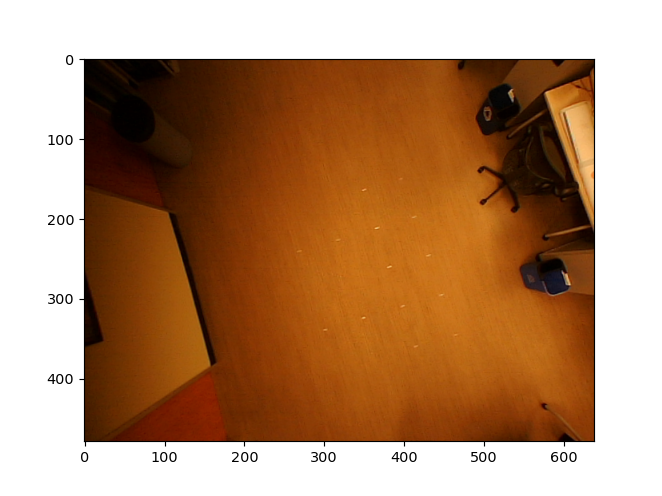

In [2]:
# read 2D image coordinates from the image shown below
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
size = im.shape
plt.figure()
plt.imshow(undistort_img(im))

In [3]:
# 2D image points
image_points = np.array([
    (329, 124),  # Point 1
    (257, 194),  # Point 2
    (332, 267),  # Point 3
    (219, 365),  # Point 4
    (485, 420),  # Point 5
    (619, 372)  # Point 6
], dtype="double")

# 3D points in real world
model_points = np.array([
    (0.53, 0.48 * 3, 0.95),  # Point 1
    (0.0, 0.48 * 2, 0.925),  # Point 2
    (0.53, 0.48, 1.244),     # Point 3
    (0, 0, 1.425),           # Point 4
    (0.53 * 2, 0, 1.875),    # Point 5
    (0.53 * 4, 0, 1.25)      # Point 6

])


camera_matrix = cam_dic["intrinsic_matrix"]
dist_coeffs = cam_dic["distortion_coefficients"]
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix,
                                                              dist_coeffs, flags=cv2.cv2.SOLVEPNP_ITERATIVE)
r_mat = cv2.Rodrigues(rotation_vector)[0]
trans_mat = combineRT(r_mat, translation_vector[:,0])
np.save("./trans_mat.npy", trans_mat)

